# Compare CONUS404 4km versus MPAS-DYAMOND 3.75 km: Wind Data

In [1]:
### Import Packages:

import numpy as np
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import wrf
from wrf import (
    cartopy_xlim,
    cartopy_ylim,
    get_cartopy,
    getvar,
    latlon_coords,
    smooth2d,
    to_np,
    interpz3d,
    interplevel
)

# Package for interpolation routine: (Could use XESMF)
from scipy.interpolate import griddata


## CONUS404 data pre-processing:

In [2]:
#Import data from CONUS404 and MPAS: Test case for Janruary 21st 00 UTC - 23 UTC. 

# CONUS404 data (coordinates kept seperately from main data, so two seperate imports)

data_conus404 = xr.open_mfdataset('/glade/campaign/collections/rda/data/d559000/wy2020/202001/wrf3d_d01_2020-01-21_*:00:00.nc',combine='nested',concat_dim='Time')

data_conus404_constants = xr.open_dataset(
    "/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4"
)

lat_conus404 = np.squeeze(data_conus404_constants.XLAT).load()
lon_conus404 = np.squeeze(data_conus404_constants.XLONG).load()

In [3]:
# Test A single time-step:

u_conus404 = data_conus404.U.sel(Time='2020-01-21T00')
v_conus404 = data_conus404.V.sel(Time='2020-01-21T00')
p_conus404 = data_conus404.P.sel(Time='2020-01-21T00')

# Destagger the CONUS404 wind data (Needed if computing more complicated variables using U,V):

u_destagger = wrf.destagger(u_conus404, -1, meta=True)
v_destagger = wrf.destagger(v_conus404, -2, meta=True)

In [4]:
### Compare u,v winds at 250 hPa, interpolate WRF data to isobaric: 

u_250_conus404 = interplevel(u_destagger, p_conus404, 25000)
v_250_conus404 = interplevel(v_destagger, p_conus404, 25000)

In [6]:
### Compute full wind from u,v & assign lat,lon coordinates to wind data:

wind_250_conus404 = np.sqrt(u_250_conus404**2 + v_250_conus404**2)

### Assign Coordinates:

wind_250_conus404 = wind_250_conus404.assign_coords({
    "lat": (("south_north", "west_east"), lat_conus404["XLAT"].data),
    "lon": (("south_north", "west_east"), lon_conus404["XLONG"].data),
})

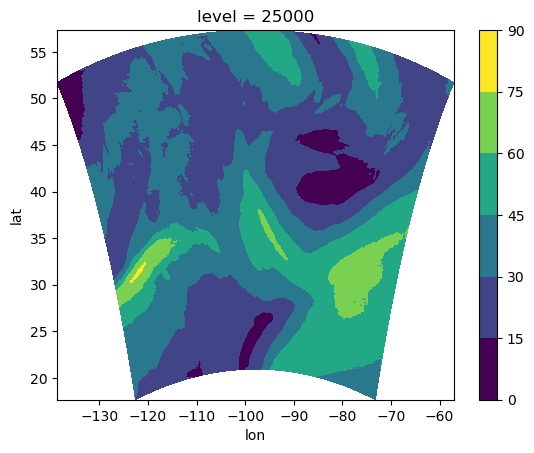

In [8]:
# Test plot:
wind_250_conus404.plot.contourf(x="lon", y="lat")

## Interpolation Routine Section:
##### CONUS404 data is on a curv-linear grid while the MPAS data (after processing from unstructured grid to latitude-longitude grid) is on a rect-linear grid. The aim is to process CONUS404 data onto a rect-linear grid to enable direct comparison between datasets.

In [23]:
### The interpolation routine: 

# To enable interpolation, begin by flattening data the lat, lon: 
points = np.column_stack((lat_conus404.data.ravel(), lon_conus404.data.ravel()))
wind_values = wind_250_conus404.values.ravel()

# Here, we specify a new rect-linear grid to interpolate to (I'm selecting to start with interger so it's easier to compare against MPAS): We also specify the +.25 so we can interpolate to a whole number
lat_new = np.arange(int(np.ceil(lat_conus404.data.min())), int(np.floor(lat_conus404.data.max())) + 0.25, 0.25)
lon_new = np.arange(int(np.ceil(lon_conus404.data.min())), int(np.floor(lon_conus404.data.max())) + 0.25, 0.25)

# Now create mesh-grid:
lon_new2d, lat_new2d = np.meshgrid(lon_new, lat_new)

### THE IMPORTANT PART, INTERPOLATE THE CURV-LINEAR CONUS404 WIND DATA TO THE NEWLY CREATED RECT-LINEAR GRID: 

wind_250_conus404_interp = griddata(points, wind_values, (lat_new2d, lon_new2d), method='linear')

In [11]:
### Currently, the data is interpolated onto rectlinear grid in a numpy format, before putting an xarray wrapper onto the interpolated CONUS404 data, let's open the MPAS data:

## MPAS data pre-processing: 

In [20]:
### MPAS DYAMOND data, just loading in the wind component data:

u_mpas = xr.open_mfdataset('/glade/derecho/scratch/alojko/MOAAP_analysis/old_transport/MPAS3.75-on-ERA5_diag.3.75km.2020-01-21*.00.00.nc',combine='nested',concat_dim='xtime').uzonal_200hPa
v_mpas = xr.open_mfdataset('/glade/derecho/scratch/alojko/MOAAP_analysis/old_transport/MPAS3.75-on-ERA5_diag.3.75km.2020-01-21*.00.00.nc',combine='nested',concat_dim='xtime').umeridional_200hPa

### Preparing the coordinates: 

time_jan = pd.date_range(start="2020-01-21T00", end="2020-01-21T23", freq="h")
u_mpas = u_mpas.assign_coords(xtime=time_jan, lon=(((u_mpas.lon + 180) % 360) - 180)).sortby('lon').load()
v_mpas = v_mpas.assign_coords(xtime=time_jan, lon=(((v_mpas.lon + 180) % 360) - 180)).sortby('lon').load()

wind_mpas = np.sqrt(u_mpas**2 + v_mpas**2)

In [30]:
### Filter the MPAS data so it matches the specified CONUS404 interpolation grid: 

wind_mpas_filt = wind_mpas[0,:,:].sel(lat=slice(lat_new[0], lat_new[-1]), lon=slice(lon_new[0], lon_new[-1]))

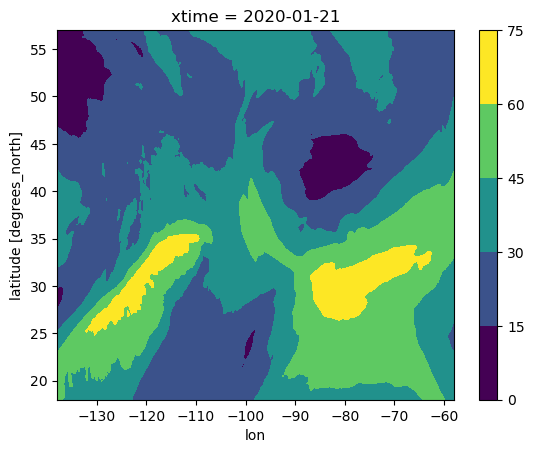

In [32]:
# test filter MPAS plot:

wind_mpas_filt.plot.contourf()

# Wrap CONUS404 data into Xarray based on MPAS post-processed data:

In [33]:
# Assuming wind_mpas_filt now has the same array size as wind_250_conus404_interp, create a zeros array with mpas data, and add on the conus404 numpy data:

wind_conus404 = xr.zeros_like(wind_mpas_filt) + wind_250_conus404_interp

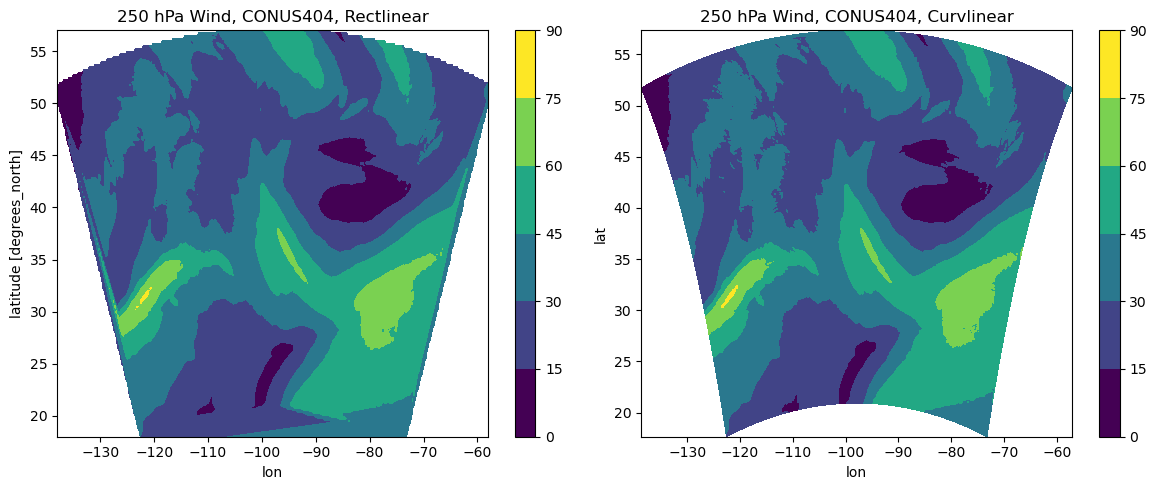

In [36]:
# Create figure and 2 axes (side by side)
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Panel 1
wind_conus404.plot.contourf(ax=axs[0])
axs[0].set_title("250 hPa Wind, CONUS404, Rectlinear")

# Panel 2
wind_250_conus404.plot.contourf(ax=axs[1], x="lon", y="lat")
axs[1].set_title("250 hPa Wind, CONUS404, Curvlinear")

plt.tight_layout()
plt.show()

### Looks similar, but some strange wind speed artefacts around the boundaries. Maybe use a different interpolation technique (from xesmf) or taper off the boundaries: 

## Side-by-side Plot comparison, MPAS verus CONUS404 on rectlinear grid:

In [42]:
# First, we cannot directly compare rectlinear versus curvlinear, but let us plot the curvlinear and rectlinear CONUS404 side-by-side:

# For simplicity and to remove the boundary artefacts, focus on a more localized region:
wind_conus404_local = wind_conus404.sel(lat=slice(21, 55), lon=slice(-122, -75))
wind_mpas_filt_local = wind_mpas_filt.sel(lat=slice(21, 55), lon=slice(-122, -75))

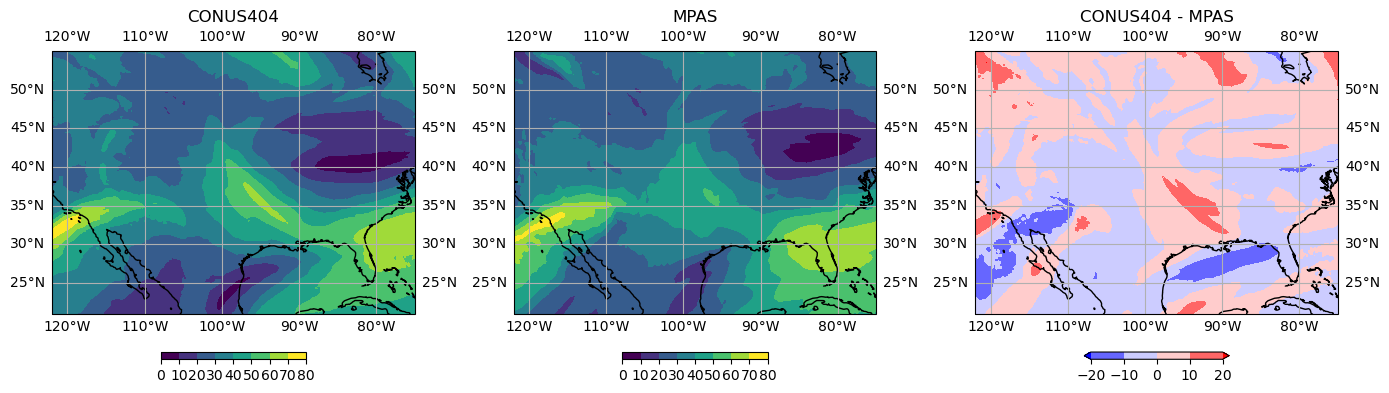

In [55]:
# Create figure and axes
fig, axs = plt.subplots(ncols=3, figsize=(14, 8),
                        subplot_kw={'projection': ccrs.PlateCarree()})  # or ccrs.LambertConformal(), etc.

# Panel 1
wind_conus404_local.plot.contourf(ax=axs[0], transform=ccrs.PlateCarree(), add_colorbar=True,cbar_kwargs={'shrink':0.4, "orientation":"horizontal","pad":0.05}, levels=9, vmin=0, vmax=80)
axs[0].coastlines()
axs[0].gridlines(draw_labels=True)
axs[0].set_title("CONUS404")

# Panel 2
wind_mpas_filt_local.plot.contourf(ax=axs[1], transform=ccrs.PlateCarree(), add_colorbar=True,cbar_kwargs={'shrink':0.4, "orientation":"horizontal","pad":0.05}, levels=9, vmin=0, vmax=80)
axs[1].coastlines()
axs[1].gridlines(draw_labels=True)
axs[1].set_title("MPAS")

# Panel 3
(wind_conus404_local - wind_mpas_filt_local).plot.contourf(ax=axs[2], transform=ccrs.PlateCarree(), add_colorbar=True,cbar_kwargs={'shrink':0.4, "orientation":"horizontal","pad":0.05}, levels=5, vmin=-20, vmax=20, cmap='bwr', extend='both')
axs[2].coastlines()
axs[2].gridlines(draw_labels=True)
axs[2].set_title("CONUS404 - MPAS")

# Shared colorbar
#cbar = fig.colorbar(axs[1].collections[0], ax=axs, orientation='horizontal', fraction=0.05, pad=0.07)
#cbar.set_label("Wind Speed")

plt.tight_layout()
plt.show()